In [2]:
!nvidia-smi

Sat Dec  6 19:31:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=0bec34d870a28f7432a54c41dcc66578ecc1a93ff11d35dee70b312b76a406ca
  Stored in directory: /root/.cache/pip/wheels/6e/65/79/33dee66cba26e8204801916dfee7481bccfd22905ebb841fe5
Successfully built nvidia-ml-py3


In [4]:
import torch
import torch.nn as nn
import time
import pynvml
from torch.utils.checkpoint import checkpoint

# --- 1. Setup & Hardware Check ---
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_memory_usage():
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used / 1024**2  # Convert to MB

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {torch.cuda.get_device_name(0)}")

# --- 2. Define the Scaled-Down LLaMA-like Model ---
class SimpleTransformer(nn.Module):
    def __init__(self, hidden_size=768, layers=6, use_checkpointing=False):
        super().__init__()
        self.use_checkpointing = use_checkpointing
        # Simple stack of linear layers to simulate Transformer blocks
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size * 4),
                nn.ReLU(),
                nn.Linear(hidden_size * 4, hidden_size)
            ) for _ in range(layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            if self.use_checkpointing:
                # This saves memory by not storing intermediate activations
                x = checkpoint(layer, x, use_reentrant=False)
            else:
                x = layer(x)
        return x

# --- 3. The Experiment Loop ---
def run_experiment(batch_sizes, use_checkpointing):
    print(f"\n--- Testing Strategy: {'CHECKPOINTING' if use_checkpointing else 'STANDARD'} ---")
    print(f"{'Batch Size':<12} | {'Memory (MB)':<12} | {'Throughput (s/s)':<18} | {'Status'}")

    model = SimpleTransformer(use_checkpointing=use_checkpointing).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    for bs in batch_sizes:
        torch.cuda.empty_cache() # Clear old memory
        try:
            # Create dummy data (Sequence Length = 1024 as typical for LLMs)
            inputs = torch.randn(bs, 1024, 768).to(device)

            # Reset peak memory tracking
            torch.cuda.reset_peak_memory_stats()
            start_mem = get_memory_usage()

            # Run Forward + Backward pass (timing it)
            start_time = time.time()
            outputs = model(inputs)
            loss = outputs.sum()
            loss.backward()
            optimizer.step()
            torch.cuda.synchronize() # Wait for GPU to finish
            end_time = time.time()

            # Calculate metrics
            peak_mem = torch.cuda.max_memory_allocated() / 1024**2
            duration = end_time - start_time
            throughput = bs / duration

            print(f"{bs:<12} | {peak_mem:<12.2f} | {throughput:<18.2f} | Success")

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"{bs:<12} | {'OOM':<12} | {'0.00':<18} | FAILED (OOM)")
                torch.cuda.empty_cache()
            else:
                print(f"{bs:<12} | Error: {e}")

# --- 4. Execute ---
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

# Run Standard (Baseline)
run_experiment(batch_sizes, use_checkpointing=False)

# Run HADA Optimization (Checkpointing)
run_experiment(batch_sizes, use_checkpointing=True)

Running on: Tesla T4

--- Testing Strategy: STANDARD ---
Batch Size   | Memory (MB)  | Throughput (s/s)   | Status
1            | 565.69       | 2.12               | Success
2            | 685.60       | 14.62              | Success
4            | 919.60       | 24.80              | Success
8            | 1387.60      | 27.46              | Success
16           | 2323.60      | 27.39              | Success
32           | 4195.60      | 27.09              | Success
64           | 7939.60      | 27.32              | Success
128          | OOM          | 0.00               | FAILED (OOM)

--- Testing Strategy: CHECKPOINTING ---
Batch Size   | Memory (MB)  | Throughput (s/s)   | Status
1            | 569.69       | 15.42              | Success
2            | 575.69       | 21.40              | Success
4            | 683.60       | 22.51              | Success
8            | 911.60       | 22.71              | Success
16           | 1367.60      | 22.92              | Success
32           |

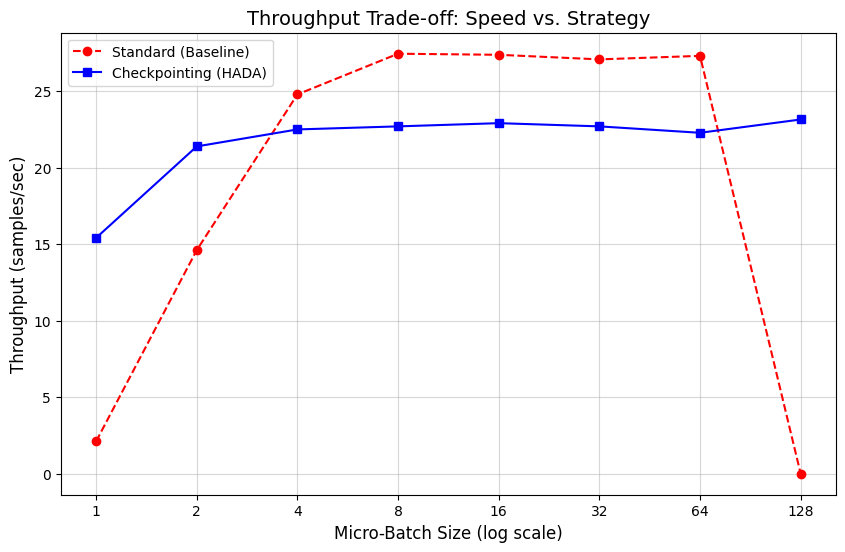

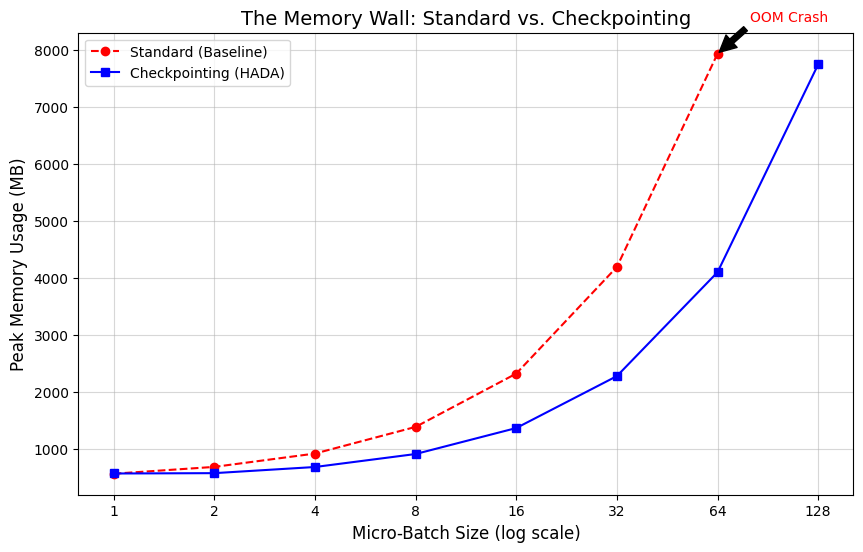

In [5]:
# graph for comparisons
import matplotlib.pyplot as plt
import numpy as np

# --- Your Experimental Data ---
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

# Standard Strategy Data (Note: BS=128 is OOM, so we use None for memory)
std_throughput = [2.12, 14.62, 24.80, 27.46, 27.39, 27.09, 27.32, 0.0]
std_memory = [565.69, 685.60, 919.60, 1387.60, 2323.60, 4195.60, 7939.60, None]

# Checkpointing Strategy Data
chk_throughput = [15.42, 21.40, 22.51, 22.71, 22.92, 22.71, 22.29, 23.16]
chk_memory = [569.69, 575.69, 683.60, 911.60, 1367.60, 2279.60, 4103.60, 7751.60]

# --- Plot 1: Throughput Comparison ---
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, std_throughput, marker='o', label='Standard (Baseline)', color='red', linestyle='--')
plt.plot(batch_sizes, chk_throughput, marker='s', label='Checkpointing (HADA)', color='blue')

plt.xscale('log', base=2)
plt.xlabel('Micro-Batch Size (log scale)', fontsize=12)
plt.ylabel('Throughput (samples/sec)', fontsize=12)
plt.title('Throughput Trade-off: Speed vs. Strategy', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.xticks(batch_sizes, labels=batch_sizes)  # Force integer labels
plt.savefig('throughput_comparison.png')
plt.show()

# --- Plot 2: Memory Wall Comparison ---
plt.figure(figsize=(10, 6))
# We only plot Standard up to 64 since 128 is OOM
plt.plot(batch_sizes[:-1], std_memory[:-1], marker='o', label='Standard (Baseline)', color='red', linestyle='--')
plt.plot(batch_sizes, chk_memory, marker='s', label='Checkpointing (HADA)', color='blue')

# Mark the OOM point for Standard
plt.annotate('OOM Crash', xy=(64, 7939), xytext=(80, 8500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='red')

plt.xscale('log', base=2)
plt.xlabel('Micro-Batch Size (log scale)', fontsize=12)
plt.ylabel('Peak Memory Usage (MB)', fontsize=12)
plt.title('The Memory Wall: Standard vs. Checkpointing', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.xticks(batch_sizes, labels=batch_sizes)
plt.savefig('memory_comparison.png')
plt.show()